# Using LSTMs to Predict LeBron James' Points in the Next Game

**Team:** Taiyo Nakai & Jonathan Wu  
**Objective:** Train an LSTM neural network to predict LeBron James' performance (e.g., over/under betting) using historical game data.  
**Methods:** LSTM model with softmax activation for multiclass outcomes. Incorporating long-term and short-term performance trends.  
**Data Source:** Basketball Reference (https://www.basketball-reference.com/players/j/jamesle01.html); CSV files for individual player game data  
**Evaluation:** Precision-based evaluation with every game betting simulation.  
**Experiments:** Hyperparameter tuning for LSTM architecture, dropout, and forget gate bias initialization.

## Imports

In [1]:
import os
import shutil
import random
import copy
import importlib

import numpy as np
import pandas as pd
import tensorflow.keras.layers as keras_layers
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import Counter
from sortedcontainers import SortedSet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Input,
    Dropout,
    Bidirectional,
)

import keras_tuner as kt

# Loading and Merging LeBron James Game Logs

This code loads and combines multiple CSV files containing LeBron James' game logs from a specified folder.  
1. Recursively searches for CSV files in the `GAME_LOG_FOLDER`.  
2. Adds each file path to a sorted set to maintain the ordered date.  
3. Reads and concatenates all CSV files into a single DataFrame `df`.  


In [2]:
GAME_LOG_FOLDER = "LeBron James Game Logs"

def fetch_files(DIRECTORY="LeBron James Game Logs"):
    csv_files = SortedSet()
    for dir_, _, files in os.walk(DIRECTORY):
        for file_name in files:
            rel_dir = os.path.relpath(dir_, DIRECTORY)
            rel_file = os.path.join(DIRECTORY, file_name)
            csv_files.add(rel_file)

    df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
    return df
    
df_uncleaned = fetch_files()
df_uncleaned

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,10/29/2003,18-303,CLE,@,SAC,L (-14),1,42:50:00,...,4,6,9,4,0,2,3,25,24.7,-9
1,2,2.0,10/30/2003,18-304,CLE,@,PHO,L (-9),1,40:21:00,...,10,12,8,1,0,7,1,21,14.7,-3
2,3,3.0,11/1/2003,18-306,CLE,@,POR,L (-19),1,39:10:00,...,4,4,6,2,0,2,3,8,5,-21
3,4,4.0,11/5/2003,18-310,CLE,NaN,DEN,L (-4),1,41:06:00,...,9,11,7,2,3,2,1,7,11.2,-3
4,5,5.0,11/7/2003,18-312,CLE,@,IND,L (-1),1,43:44:00,...,5,5,3,0,0,7,2,23,9,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,78,78.0,4/6/2025,40-098,LAL,@,OKC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1763,79,79.0,4/8/2025,40-100,LAL,@,OKC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1764,80,80.0,4/9/2025,40-101,LAL,@,DAL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1765,81,81.0,4/11/2025,40-103,LAL,NaN,HOU,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN


# Renaming Columns in Game Log Data

This code renames two in the game log DataFrame for better readability.  

1. Renames the columns `'Unnamed: 5'` and `'Unnamed: 7'` to `'Location'` and `'Score Differential'`, respectively.  


In [3]:
def df_rename(df):
    df = df.rename(columns={'Unnamed: 5': 'Location', 'Unnamed: 7': 'Score Differential'})
    return df

df_renamed = df_rename(df_uncleaned.copy())
df_renamed.columns.values

array(['Rk', 'G', 'Date', 'Age', 'Tm', 'Location', 'Opp',
       'Score Differential', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-'], dtype=object)

# Data Cleaning & Feature Engineering

This code performs several data preprocessing steps on the game log DataFrame to clean.  
1. Drops rows where the `'G'` (Game) column is NaN.  
2. Converts the `'Date'` column to datetime format, and extracts the day, month, and year into new columns.  
3. Drops irrelevant columns like `'Rk'`, `'G'`, `'Date'`, etc.  
4. Maps categorical values in the `'Location'` column (home or away) and updates `'Opp'` and `'Tm'` columns to numeric values representing teams.  
5. Converts the `'MP'` column (minutes played) into a float, representing total minutes played in decimal format.  
6. Calculates and updates the `'Age'` column by converting it from a year-day format to a float representing age in years.  
7. Converts all columns to `float` type for consistency.  


In [4]:
def cleansing(df):
    df.drop(df.index[df['G'].isnull()], inplace = True)

    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    df = df.drop(columns=['Rk', 'G', 'Date', 'Score Differential', 'GS', 'GmSc', '+/-', 'ORB', 'DRB', 'TRB', 
                          'AST', 'STL', 'BLK', 'TOV', 'PF', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
                          '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
                          'BLK', 'TOV', 'PF'])

    df['Location'] = df['Location'].map({'@': 1, np.nan: 0}) 

    df['Opp'] = df['Opp'].map({'ATL': 1, 'BOS': 2, 'BRK': 3, 'NJN': 3, 'CHA': 4, 'CHO': 4,
                               'CHI': 5, 'CLE': 6, 'DAL': 7, 'DEN': 8, 'DET': 9, 'GSW': 10, 
                               'HOU': 11, 'IND': 12, 'LAC': 13, 'LAL': 14, 'MEM': 15, 'MIA': 16, 
                               'MIL': 17, 'MIN': 18, 'NOH': 19, 'NOK': 19, 'NOP': 19, 'NYK': 20, 
                               'OKC': 21, 'ORL': 22, 'PHI': 23, 'PHO': 24, 'POR': 25, 'SAC': 26,
                               'SAS': 27, 'SEA': 28, 'TOR': 29, 'UTA': 30, 'WAS': 31}) 

    df['Tm'] = df['Tm'].map({'ATL': 1, 'BOS': 2, 'BRK': 3, 'NJN': 3, 'CHA': 4, 'CHO': 4,
                             'CHI': 5, 'CLE': 6, 'DAL': 7, 'DEN': 8, 'DET': 9, 'GSW': 10, 
                             'HOU': 11, 'IND': 12, 'LAC': 13, 'LAL': 14, 'MEM': 15, 'MIA': 16, 
                             'MIL': 17, 'MIN': 18, 'NOH': 19, 'NOK': 19, 'NOP': 19, 'NYK': 20, 
                             'OKC': 21, 'ORL': 22, 'PHI': 23, 'PHO': 24, 'POR': 25, 'SAC': 26,
                             'SAS': 27, 'SEA': 28, 'TOR': 29, 'UTA': 30, 'WAS': 31})

    for i, row in df.iterrows():
        year, days = df.loc[i]['Age'].split('-')
        if int(df.loc[i]['Year']) % 4 == 0:
            days = int(days) / 366
        else:
            days = int(days) / 365
        df.loc[i, 'Age'] = int(year) + days

    df = df.astype(float)
    return df

df_cleaned = cleansing(df_renamed.copy())
df_cleaned

,Age,Tm,Location,Opp,PTS,Day,Month,Year
0,18.830137,6.0,1.0,26.0,25.0,29.0,10.0,2003.0
1,18.832877,6.0,1.0,24.0,21.0,30.0,10.0,2003.0
2,18.838356,6.0,1.0,25.0,8.0,1.0,11.0,2003.0
3,18.849315,6.0,0.0,8.0,7.0,5.0,11.0,2003.0
4,18.854795,6.0,1.0,12.0,23.0,7.0,11.0,2003.0
...,...,...,...,...,...,...,...,...
1762,40.268493,14.0,1.0,21.0,-1.0,6.0,4.0,2025.0
1763,40.273973,14.0,1.0,21.0,-1.0,8.0,4.0,2025.0
1764,40.276712,14.0,1.0,7.0,-1.0,9.0,4.0,2025.0
1765,40.282192,14.0,0.0,11.0,-1.0,11.0,4.0,2025.0


# Data Scaling and Splitting for Time-Series Model

This code scales the features and target variable, and prepares the data for training a time-series model using sliding windows.   
1. **Scaling:**  
   - Scales the feature columns (excluding `'PTS'`) using `MinMaxScaler`.  
   - Scales the target column `'PTS'` using the same scaler.  
2. **Data Splitting:**  
   - Defines a `split()` function that creates sequences of past data points (with a specified window length) to predict future values.  
3. **Train/Test Split:**  
   - Splits the scaled features into training (80%) and testing (20%) sets.  
4. **Windowing:**  
   - Applies the `split()` function to create input-output pairs for training and testing using a variable sliding window length.  
5. **Reshaping:**  
   - Reshapes the input data into 3D arrays suitable for feeding into a neural network (samples, time steps, features).  
  

In [5]:
WINDOW = 5
YEAR_LIMIT = 2022

def split_train_test(df, window, year_limit):
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df.drop(columns=['PTS']))
    scaled_target = scaler.fit_transform(df[['PTS']])

    def split(dataset, window=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-window-1):
            a = dataset[i:(i+window), 0]
            dataX.append(a)
            dataY.append(dataset[i + window, 0])
        return np.array(dataX), np.array(dataY)

    train_size = df[(df['Year'] < year_limit) | ((df['Year'] == year_limit) & (df['Month'] < 7))].shape[0]
    test_size = len(scaled_target) - train_size
    train, test = scaled_features[0:train_size,:], scaled_target[train_size:len(scaled_target),:]

    trainX, trainY = split(train, window)
    testX, testY = split(test, window)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX, trainY, testY, scaler

trainX, testX, trainY, testY, scaler = split_train_test(df_cleaned.copy(), WINDOW, YEAR_LIMIT)

# Building and Training the LSTM Model

This code defines, compiles, and trains a LSTM model for predicting LeBron James' performance.  
1. **Model Architecture:**  
   - Creates a sequential model with the layers shown below
2. **Compilation:**  
   - Compiles the model using the Adam optimizer, mean squared error (MSE) loss, and mean absolute error (MAE) metric.  
3. **Callbacks:**  
   - Implements early stopping based on validation MAE with a patience of 10 epochs.  
4. **Training:**  
   - Trains the model for up to 100 epochs, using a batch size of 32, with validation data and the early stopping callback.  
5. **Output:** The model's training history is stored in `LSTM_History`.


In [6]:
def build_LSTM():
    LSTM = getattr(layers, 'LSTM') # DO NOT REMOVE; this line allows for this function to be rerun without restarting
    LSTM_Model = Sequential([
        Input(shape=(trainX.shape[1], trainX.shape[2])),
        Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001))),
        LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.25),
        LSTM(units=64,return_sequences=True),
        Dropout(0.25),
        LSTM(units=32,return_sequences=True),
        Dropout(0.25),
        LSTM(units=32),
        Dropout(0.25),
        Dense(32, kernel_regularizer=l2(0.001)),
        Dense(1, kernel_regularizer=l2(0.001), bias_initializer='zeros')
    ])

    LSTM_Model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)
    ]

    LSTM_History = LSTM_Model.fit(
        trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), callbacks=callbacks
    )

    return LSTM_Model, LSTM_History

LSTM, _ = build_LSTM()

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4421 - mae: 0.3133 - val_loss: 0.1622 - val_mae: 0.2006
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1239 - mae: 0.1955 - val_loss: 0.0620 - val_mae: 0.1345
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 - mae: 0.0690 - val_loss: 0.0386 - val_mae: 0.1041
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - mae: 0.0508 - val_loss: 0.0324 - val_mae: 0.0982
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - mae: 0.0439 - val_loss: 0.0287 - val_mae: 0.0969
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - mae: 0.0417 - val_loss: 0.0255 - val_mae: 0.0899
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147 - mae: 0.0363 - val_loss: 0.0237 - val_mae: 0.0928
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - mae: 0.0411 - val_loss: 0.0245 - val_mae: 0.0965
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - mae:

# Evaluating and Making Predictions with the LSTM Model

This code performs recurrent predictions using an LSTM model, updating test data with noisy predictions to simulate variability in the forecast.

### Functions:

1. **`new_window(X_test, scaled_prediction)`**:
    - **Purpose**: Updates the `X_test` data by replacing values in the windows containing `0` with the given `scaled_prediction` value.
    - Iterates over `X_test`, and if a window contains `0`, it replaces the `0` with `scaled_prediction`, decreasing the `replacement_index` until all applicable values are replaced.

2. **`new_target(y_test, scaled_prediction)`**:
    - **Purpose**: Updates the `y_test` target values by replacing the first occurrence of `0` with `scaled_prediction`.
    - Finds the first `0` in `y_test` and replaces it with `scaled_prediction`.

3. **`predict_with_noise(prediction)`**:
    - **Purpose**: Adjusts a given prediction by adding noise based on statistical properties of historical data (`PTS`).
    - Generates noise from a normal distribution based on the mean and standard deviation of the `PTS` column in `df`. The noisy prediction is adjusted depending on whether the noise is greater than the original prediction..

4. **`recurrent_predictions(X_test, y_test, current_length)`**:
    - **Purpose**: Makes recurrent predictions with the LSTM model, updates the `PTS` column of a dataframe, and modifies the test data (`X_test`, `y_test`) based on the predictions.
    - Predicts future values using the LSTM model and inverse scales the predictions.
    - The prediction is adjusted with noise by calling `predict_with_noise()`.
    - Updates `X_test` and `y_test` by calling `new_window()` and `new_target()` with the updated prediction.
    - Repeats this process until all values are predicted.

In [7]:
def LSTM_Predict(model, df, X_test, y_test, year_limit, early_break=False):
    def new_window(X_test, scaled_prediction):
        """
        Updates the windows in the test data (X_test) by replacing the first occurrence of 0 
        with the scaled prediction value at the appropriate index.
        """
        replacement_index = 4
        for _ in X_test:
            for window in _:
                if 0 in window and replacement_index >= 0:
                    window[replacement_index] = scaled_prediction.item()
                    replacement_index -= 1
                elif replacement_index < 0:
                    break

    def new_target(y_test, scaled_prediction):
        """
        Updates the target values (y_test) by replacing the first occurrence of 0 with the 
        scaled prediction value.
        """
        index = np.where(y_test == 0)[0][0]
        y_test[index] = scaled_prediction.item()

    def predict_with_noise(prediction, last_game_pts):
        """
        Adds noise to the given prediction by drawing from a normal distribution based on 
        historical data statistics (mean and std of 'PTS'). The noisy prediction is adjusted 
        depending on whether the noise is greater than the original prediction.
        """
        stats = df[(df['Year'] < year_limit) | ((df['Year'] == year_limit) & (df['Month'] < 7))]['PTS'].describe()
        gaussian = np.random.normal(stats['mean'], stats['std'], size=1)
        if gaussian > prediction:
            return np.round((gaussian + prediction) / 1.75, 0)
        else:
            return np.round((gaussian + prediction) / 2.8, 0)

        
    def recurrent_predictions(X_test, y_test, current_length):
        """
        Makes recursive predictions using the LSTM model, updating the 'PTS' column in the 
        DataFrame with noisy predictions at each step. The process continues until all test 
        data is used.
        """
        n = len(X_test)
        temp_df = df.copy()
        while current_length < n:
            current_X, current_y = X_test[:current_length], y_test[:current_length-1]

            predictions = model.predict(np.array(current_X))
            predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
            predictions = [round(points[0]) for points in predictions]
            actual = scaler.inverse_transform(np.array(current_y).reshape(-1, 1))
            if early_break:
                return predictions, actual
            
            index = temp_df[temp_df['PTS'] == -1].index[0]
            temp_df.loc[index, 'PTS'] = predict_with_noise(predictions[-1], predictions[-2])
            
            temp_scaling = scaler.fit_transform(temp_df[['PTS']])
            scaled_index = temp_scaling.tolist().index([0])-1
            scaled_number = temp_scaling[scaled_index]

            new_window(X_test, scaled_number)
            new_target(y_test, scaled_number)

            current_length += 1

        return predictions, actual

    original_length = testY.tolist().index(0) + 1
    predictions, actual = recurrent_predictions(copy.deepcopy(testX), copy.deepcopy(testY), original_length)
    
    return predictions, actual, original_length - 2

predictions, actual, recent_game = LSTM_Predict(LSTM, df_cleaned.copy(), testX, testY, YEAR_LIMIT)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━

# Plotting Actual vs. Predicted Values

This code visualizes the actual and predicted values of points scored for the test set.


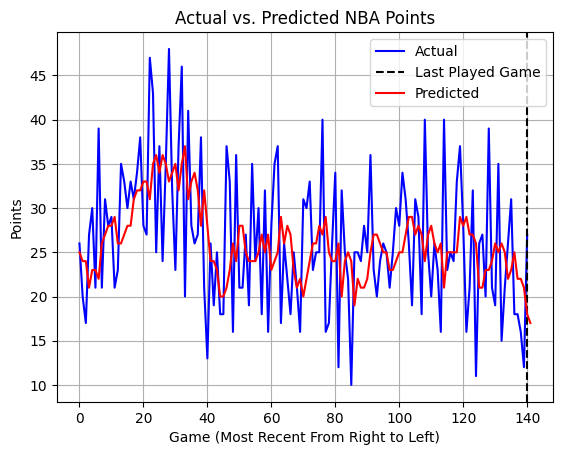

In [8]:
plt.plot(actual[:recent_game+1], label='Actual', color='blue')
plt.axvline(x=recent_game, color='black', linestyle='--', label='Last Played Game')
plt.plot(predictions[:recent_game+2], label='Predicted', color='red')

plt.title('Actual vs. Predicted NBA Points')
plt.xlabel('Game (Most Recent From Right to Left)')
plt.ylabel('Points')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

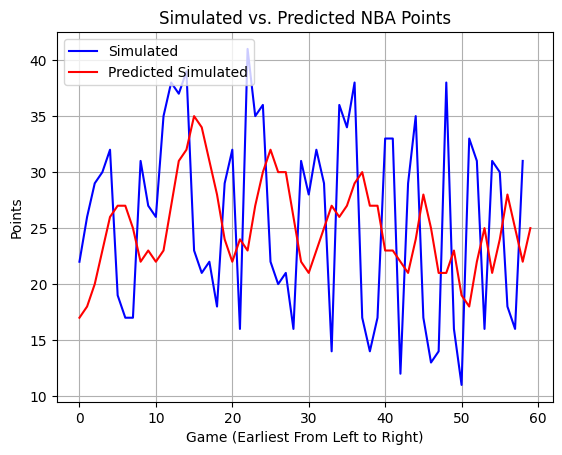

In [9]:
plt.plot(actual[recent_game+1:], label='Simulated', color='blue')
plt.plot(predictions[recent_game+1:], label='Predicted Simulated', color='red')

plt.title('Simulated vs. Predicted NBA Points')
plt.xlabel('Game (Earliest From Left to Right)')
plt.ylabel('Points')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

# Testing Next Game's Score Prediction Distribution

We might want to see what prediction score distribution that the model would predict given the last 5 (real) games played by LeBron James and see if there's a general direction or pattern to what the model thinks.

Let's run 100 different trials and graph the frequency of the points predicted.

In [ ]:
def get_next_game_distribution(trials=100):
    distribution = []
    for trial in range(trials):
        LSTM, _ = build_LSTM()
        predictions, actual, original_length = LSTM_Predict(
            LSTM, df_cleaned.copy(), testX, testY, year_limit=2022, early_break=True
        )
        distribution.append(predictions[original_length-2])
        if trial == trials-1:
            return distribution, predictions, actual, original_length-2

dist, predictions, actual, recent_game = get_next_game_distribution()

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4573 - mae: 0.3299 - val_loss: 0.1633 - val_mae: 0.2023
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1215 - mae: 0.1858 - val_loss: 0.0572 - val_mae: 0.1196
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0392 - mae: 0.0622 - val_loss: 0.0381 - val_mae: 0.1039
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263 - mae: 0.0514 - val_loss: 0.0323 - val_mae: 0.0964
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - mae: 0.0431 - val_loss: 0.0290 - val_mae: 0.0957
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - mae: 0.0448 - val_loss: 0.0255 - val_mae: 0.0882
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - mae: 0.0415 - val_loss: 0.0235 - val_mae: 0.0889
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - mae: 0.0367 - val_loss: 0.0219 - val_mae: 0.0853
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - mae:

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - mae: 0.0347 - val_loss: 0.0184 - val_mae: 0.0833
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0334 - val_loss: 0.0188 - val_mae: 0.0886
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - mae: 0.0393 - val_loss: 0.0175 - val_mae: 0.0827
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0312 - val_loss: 0.0172 - val_mae: 0.0790
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0332 - val_loss: 0.0172 - val_mae: 0.0837
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0311 - val_loss: 0.0178 - val_mae: 0.0947
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0377 - val_loss: 0.0173 - val_mae: 0.0914
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0322 - val_loss: 0.0183 - val_mae: 0.0937
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - mae: 0.0369 - val_loss: 0.0199 - val_mae: 0.0870
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - mae: 0.0339 - val_loss: 0.0201 - val_mae: 0.0961
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - mae: 0.0389 - val_loss: 0.0186 - val_mae: 0.0829
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - mae: 0.0325 - val_loss: 0.0182 - val_mae: 0.0821
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0356 - val_loss: 0.0180 - val_mae: 0.0901
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - mae: 0.0348 - val_loss: 0.0175 - val_mae: 0.0831
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mae: 0.0358 - val_loss: 0.0175 - val_mae: 0.0871
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0327 - val_loss: 0.0172 - val_mae: 0.0872
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - mae: 0.0356 - val_loss: 0.0196 - val_mae: 0.0864
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - mae: 0.0357 - val_loss: 0.0189 - val_mae: 0.0851
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - mae: 0.0351 - val_loss: 0.0185 - val_mae: 0.0866
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mae: 0.0340 - val_loss: 0.0188 - val_mae: 0.0887
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4527 - mae: 0.3335 - val_loss: 0.1655 - val_mae: 0.2085
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1249 - mae: 0.2004 - val_loss: 0.0649 - val_mae: 0.1428
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 - mae: 0.0826 - val_loss: 0.0393 - val_mae: 0.1094
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - mae: 0.0547 - val_loss: 0.0326 - val_mae: 0.1008
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - mae: 0.0358 - val_loss: 0.0175 - val_mae: 0.0827
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0312 - val_loss: 0.0172 - val_mae: 0.0871
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0358 - val_loss: 0.0174 - val_mae: 0.0874
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0317 - val_loss: 0.0168 - val_mae: 0.0860
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.4537 - mae: 0.3314 - val_loss: 0.1636 - val_mae: 0.2043
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1231 - mae: 0.1946 - val_loss: 0.0630 - val_mae: 0.1366
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417 - mae: 0.0720 - val_loss: 0.0390 - val_mae: 0.1064
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - mae: 0.0523 - val_loss: 0.0332 - val_mae: 0.1019
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0337 - val_loss: 0.0180 - val_mae: 0.0846
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.4393 - mae: 0.3143 - val_loss: 0.1699 - val_mae: 0.2126
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1257 - mae: 0.1950 - val_loss: 0.0641 - val_mae: 0.1366
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420 - mae: 0.0707 - val_loss: 0.0404 - val_mae: 0.1079
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - mae: 0.0529 - val_loss: 0.0345 - val_mae: 0.1018
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - mae: 0.0444 - val_loss: 0.0307 - val_mae: 0.0978
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - mae: 0.0515 - val_loss: 0.0269 - val_mae: 0.0903
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - mae: 0.0421 - val_loss: 0.0250 - val_mae: 0.0916
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - mae: 0.0367 - val_loss: 0.0185 - val_mae: 0.0821
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0346 - val_loss: 0.0182 - val_mae: 0.0809
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - mae: 0.0399 - val_loss: 0.0182 - val_mae: 0.0891
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - mae: 0.0361 - val_loss: 0.0176 - val_mae: 0.0878
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0327 - val_loss: 0.0174 - val_mae: 0.0819
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0337 - val_loss: 0.0170 - val_mae: 0.0855
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0357 - val_loss: 0.0168 - val_mae: 0.0875
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4599 - mae: 0.3339 - val_loss: 0.1636 - val_mae: 0.2028
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - mae: 0.0369 - val_loss: 0.0178 - val_mae: 0.0869
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - mae: 0.0366 - val_loss: 0.0181 - val_mae: 0.0875
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.4486 - mae: 0.3227 - val_loss: 0.1676 - val_mae: 0.2101
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1239 - mae: 0.1928 - val_loss: 0.0574 - val_mae: 0.1246
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 - mae: 0.0630 - val_loss: 0.0386 - val_mae: 0.1070
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 - mae: 0.0582 - val_loss: 0.0313 - val_mae: 0.0945
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - mae: 0.0440 - val_loss: 0.0278 - val_mae: 0.0936
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - mae: 0.0426 - val_loss: 0.0250 - val_mae: 0.0895
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - mae: 0.0333 - val_loss: 0.0179 - val_mae: 0.0905
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - mae: 0.0341 - val_loss: 0.0176 - val_mae: 0.0912
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - mae: 0.0390 - val_loss: 0.0171 - val_mae: 0.0824
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - mae: 0.0375 - val_loss: 0.0172 - val_mae: 0.0898
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.4454 - mae: 0.3184 - val_loss: 0.1699 - val_mae: 0.2157
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1243 - mae: 0.1970 - val_loss: 0.0617 - val_mae: 0.1376
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0421 - mae: 0.0771 - val_loss: 0.0395 - val_mae: 0.1094
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mae: 0.0570 - val_loss: 0.0335 - val_mae: 0.1022
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - mae: 0.0360 - val_loss: 0.0191 - val_mae: 0.0869
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0328 - val_loss: 0.0187 - val_mae: 0.0857
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mae: 0.0328 - val_loss: 0.0184 - val_mae: 0.0885
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - mae: 0.0333 - val_loss: 0.0206 - val_mae: 0.0947
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - mae: 0.0358 - val_loss: 0.0183 - val_mae: 0.0891
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4600 - mae: 0.3426 - val_loss: 0.1568 - val_mae: 0.1963
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1228 - mae: 0.1971 - val_loss: 0.0641 - val_mae: 0.1414
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0428 - mae: 0.0816 - val_loss: 0.0388 - val_mae: 0.1079
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - mae: 0.0370 - val_loss: 0.0207 - val_mae: 0.0881
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - mae: 0.0370 - val_loss: 0.0200 - val_mae: 0.0901
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - mae: 0.0349 - val_loss: 0.0194 - val_mae: 0.0902
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - mae: 0.0346 - val_loss: 0.0184 - val_mae: 0.0848
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - mae: 0.0339 - val_loss: 0.0188 - val_mae: 0.0901
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - mae: 0.0341 - val_loss: 0.0176 - val_mae: 0.0882
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - mae: 0.0342 - val_loss: 0.0173 - val_mae: 0.0885
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - mae: 0.0354 - val_loss: 0.0170 - val_mae: 0.0861
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.0348 - val_loss: 0.0191 - val_mae: 0.0894
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4492 - mae: 0.3264 - val_loss: 0.1585 - val_mae: 0.1963
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1233 - mae: 0.1931 - val_loss: 0.0661 - val_mae: 0.1431
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0424 - mae: 0.0734 - val_loss: 0.0396 - val_mae: 0.1086
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - mae: 0.0555 - val_loss: 0.0326 - val_mae: 0.0983
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mae: 0.0475 - val_loss: 0.0289 - val_mae: 0.0972
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - mae: 0.0423 - val_loss: 0.0259 - val_mae: 0.0922
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - mae: 0.0408 - val_loss: 0.0237 - val_mae: 0.0851
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - mae: 0.0399 - val_loss: 0.0259 - val_mae: 0.0913
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - mae: 0.0413 - val_loss: 0.0236 - val_mae: 0.0912
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - mae: 0.0383 - val_loss: 0.0222 - val_mae: 0.0926
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - mae: 0.0362 - val_loss: 0.0207 - val_mae: 0.0826
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - mae: 0.0388 - val_loss: 0.0198 - val_mae: 0.0815
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - mae: 0.0343 - val_loss: 0.0191 - val_mae: 0.0850
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - mae: 0.0333 - val_loss: 0.0184 - val_mae: 0.0828
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0355 - val_loss: 0.0185 - val_mae: 0.0910
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - mae: 0.0341

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - mae: 0.0697 - val_loss: 0.0390 - val_mae: 0.1044
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - mae: 0.0539 - val_loss: 0.0334 - val_mae: 0.0988
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - mae: 0.0492 - val_loss: 0.0290 - val_mae: 0.0926
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - mae: 0.0395 - val_loss: 0.0263 - val_mae: 0.0915
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - mae: 0.0384 - val_loss: 0.0243 - val_mae: 0.0881
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0389 - val_loss: 0.0226 - val_mae: 0.0876
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - mae: 0.0423 - val_loss: 0.0214 - val_mae: 0.0899
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - mae: 0.0370 - val_loss: 0.0202 - val_mae: 0.0809
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.0383 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0322 - val_loss: 0.0171 - val_mae: 0.0820
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0309 - val_loss: 0.0171 - val_mae: 0.0895
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0306 - val_loss: 0.0169 - val_mae: 0.0893
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0317 - val_loss: 0.0166 - val_mae: 0.0843
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0316 - val_loss: 0.0168 - val_mae: 0.0903
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0318 - val_loss: 0.0167 - val_mae: 0.0838
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.4402 - mae: 0.3105 - val_loss: 0.1773 - val_mae: 0.2268
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1244 - mae: 0.1954 - val_loss: 0.0625 - val_mae: 0.1357
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
frequency = Counter(dist)

points = list(frequency.keys())
points_frequency = list(frequency.values())

plt.title('Frequency of Next Game\'s Predicted Points')
plt.bar(points, points_frequency)
plt.xlabel('Predicted Points')
plt.ylabel('Frequency')
plt.xticks(np.arange(min(frequency.keys()), max(frequency.keys()) + 1))
legend_elements = [
    Patch(facecolor='green', label=f"Last Game: {int(actual[recent_game].item())}"),
    Patch(facecolor='red', edgecolor='black', label=f"Last Predicted Score: {predictions[recent_game]}")
]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

# True Metric: Evaluation on Betting (Prop) Lines
While we did use MAE to best fit the model on LeBron James' historical data in points scored, we evaluted the ability of the model on a second metric: how many prop lines can it accurate hit and/or predict?

To do this, we scraped data from FanDuel's historical prop lines for LeBron James from 2023 to the present and compared it the actual points he scored that day, and how many points our model predicts him to actually score.

We want to maximize the amount of money earned if we were to truly bet on Lebron James.

In [ ]:
bettinglinesdf = pd.read_csv("Betting_Lines_2024_2025")
bettinglines = np.array(bettinglinesdf["Line"])

In [ ]:
predictions_combined = predictions[-window-2:] + predictionstemp
y_combined = np.array(data2024["PTS"])
plt.plot(y_combined, label='Actual', color='blue')
plt.plot(predictions_combined, label='Predicted', color='red')
plt.plot(bettinglines, label='Betting Line', color='goldenrod')

plt.title('Actual vs Predicted Points by Lebron James, 2024-2025')
plt.xlabel('Game (Most Recent From Left to Right)')
plt.ylabel('Points')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

# Betting in Different Ways
We will retroactively "bet" on points scored by Lebron James in several different ways, and see if one works better than others.

## Preparation: Predicting the rest of December 2024 
(as of December 4, the future)

In [ ]:
datafall2024 = pd.read_csv("December_2024_data")
datafall2024.tail()

## Baseline: Bet the Favorite Every Game
If one simply bet on the favorite between over and under for every game, how would they have fared so far?

In [ ]:
bettinglinesdf['Actual Points'] = np.array(data2024['PTS'])
bettinglinesdf['Predicted Points'] = np.array(predictions_combined)
bettinglinesdf

In [ ]:
spendings = []  # Use a list to collect spendings
earnings = []   # Use a list to collect earnings

for index, row in bettinglinesdf.iterrows():
    # Assign variables based on columns
    line = row['Line']
    over = row['Over']
    under = row['Under']
    actual = row['Actual Points']
    predicted = row['Predicted Points']

    # Betting over
    if over < under:
        # Positive odds
        if over > 0:
            spendings.append(100)
            if actual > line:
                earnings.append(100 + over)
            else:
                earnings.append(0)  # Add 0 if no earnings
        # Negative odds
        elif over < 0:
            spendings.append(-over)
            if actual > line:
                earnings.append(100 - over)
            else:
                earnings.append(0)  # Add 0 if no earnings
    # Betting under
    elif over > under:
        if under > 0:
            spendings.append(100)
            if actual < line:
                earnings.append(100 + under)
            else:
                earnings.append(0)  # Add 0 if no earnings
        elif under < 0:
            spendings.append(-under)
            if actual < line:
                earnings.append(100 - under)
            else:
                earnings.append(0)  # Add 0 if no earnings

# Convert lists to NumPy arrays
spendings = np.array(spendings)
earnings = np.array(earnings)

# Calculate total spendings and earnings
total_spendings = spendings.sum()
total_earnings = earnings.sum()

print(f"We bet ${total_spendings} to earn ${total_earnings} \n for a net profit of ${total_earnings - total_spendings} \n or ${round((total_earnings - total_spendings)/len(spendings), 2)} per game")
d = {'spendings': spendings, 'earnings': earnings}
pd.DataFrame(data=d)


Evidently, a person that bet on the favorite every game lost money.

## Method 1: Predicted vs. Betting Line

In [ ]:
spendings = []  # Use a list to collect spendings
earnings = []   # Use a list to collect earnings

for index, row in bettinglinesdf.iterrows():
    # Assign variables based on columns
    line = row['Line']
    over = row['Over']
    under = row['Under']
    actual = row['Actual Points']
    predicted = row['Predicted Points']

    # Betting over
    if predicted > line:
        # Positive odds
        if over > 0:
            spendings.append(100)
            if actual > line:
                earnings.append(100 + over)
            else:
                earnings.append(0)  # Add 0 if no earnings
        # Negative odds
        elif over < 0:
            spendings.append(-over)
            if actual > line:
                earnings.append(100 - over)
            else:
                earnings.append(0)  # Add 0 if no earnings
    # Betting under
    elif predicted < line:
        if under > 0:
            spendings.append(100)
            if actual < line:
                earnings.append(100 + under)
            else:
                earnings.append(0)  # Add 0 if no earnings
        elif under < 0:
            spendings.append(-under)
            if actual < line:
                earnings.append(100 - under)
            else:
                earnings.append(0)  # Add 0 if no earnings

# Convert lists to NumPy arrays
spendings = np.array(spendings)
earnings = np.array(earnings)

# Calculate total spendings and earnings
total_spendings = spendings.sum()
total_earnings = earnings.sum()

print(f"We bet ${total_spendings} to earn ${total_earnings} \n for a net profit of ${total_earnings - total_spendings} \n or ${round((total_earnings - total_spendings)/len(spendings), 2)} per game")
d = {'spendings': spendings, 'earnings': earnings}
pd.DataFrame(data=d)

This ended up being a worse strategy than the baseline.